In [63]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

import os
import time
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch.nn.functional as F
from torch.nn.functional import relu, sigmoid, tanh
from datetime import datetime

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [27]:
# Installing and Loading Kaggle API

!pip install kaggle
!pip install kagglehub
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
cp: kaggle.json: No such file or directory
chmod: /Users/joebeyrer/.kaggle/kaggle.json: No such file or directory


In [28]:
# Downloading Cityescapes Pix2Pix Dataset

!kaggle datasets download -d balraj98/cityscapes-pix2pix-dataset
!unzip cityscapes-pix2pix-dataset.zip -d cityscapes_pix2pix_dataset

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/bin/kaggle", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/kaggle/api/kaggle_api_extended.py", line 1734, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
unzip:  cannot find or open cityscapes-pix2pix-dataset.zip, cityscapes-pix2pix-dataset.zip.zip or cityscapes-pix2pix-dataset.zip.Z

In [29]:
import os
# Point the cache to wherever you like (e.g., current working directory)
os.environ["KAGGLEHUB_CACHE"] = os.getcwd()

import kagglehub
path = kagglehub.dataset_download("balraj98/cityscapes-pix2pix-dataset")
print("Downloaded to:", path)

Downloaded to: /Users/joebeyrer/Documents/GitHub/FireGEN/FireGEN/joe_test_models/datasets/balraj98/cityscapes-pix2pix-dataset/versions/1


In [30]:
# Creating Dataset Class for Cityscapes (Pix2Pix)

class CityscapesDataset(Dataset):

    def __init__(self, data_dir, transform=None):

        self.data_dir = data_dir
        self.transform = transform
        self.files = sorted(os.listdir(self.data_dir))
        self.image_paths = []
        self.label_paths = []


    def __len__(self):

        return len(self.files)


    def __getitem__(self, idx):

        image_path = os.path.join(self.data_dir, self.files[idx])
        image = Image.open(image_path).convert("RGB")

        width, height = image.size
        real_image = image.crop((0, 0, width // 2, height))                     # due to data being concatenated horizontally
        segmented_image = image.crop((width //2, 0, width, height))             # due to data being concatenated horizontally

        if self.transform:
            real_image = self.transform(real_image)
            segmented_image = self.transform(segmented_image)

        return segmented_image, real_image

In [40]:
# Loading Cityscapes Pix2Pix Dataset

SIZE = 256
batch_size = 32
root_dir = "./datasets/balraj98/cityscapes-pix2pix-dataset/versions/1"
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')

data_transforms = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),                     # normalizing range (-1, 1)
])

train_dataset = CityscapesDataset(train_dir, transform=data_transforms)
val_dataset = CityscapesDataset(val_dir, transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])


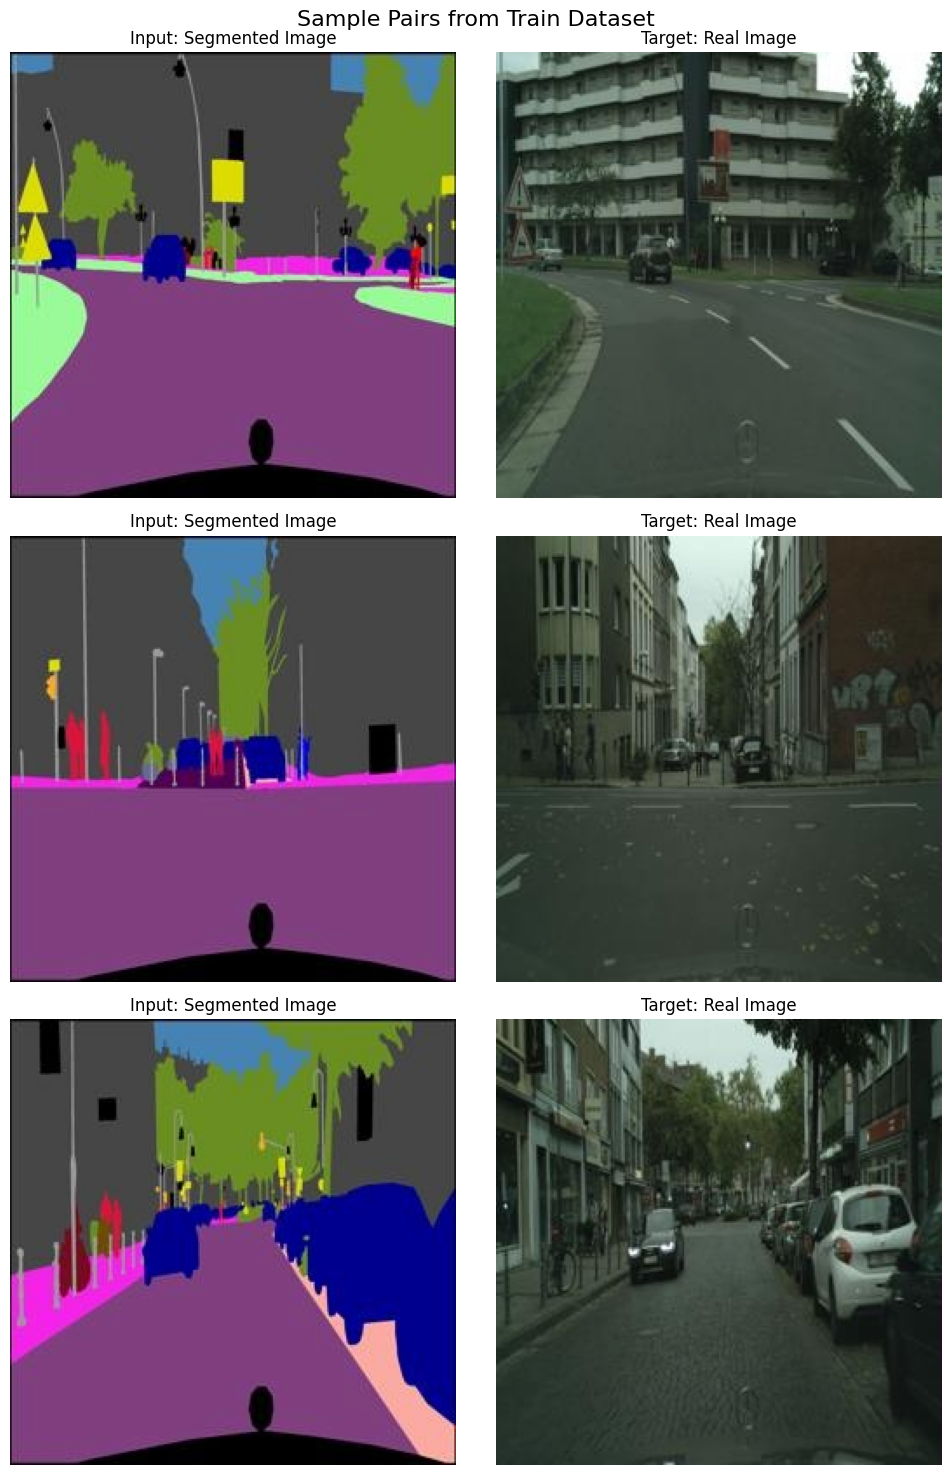

torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])


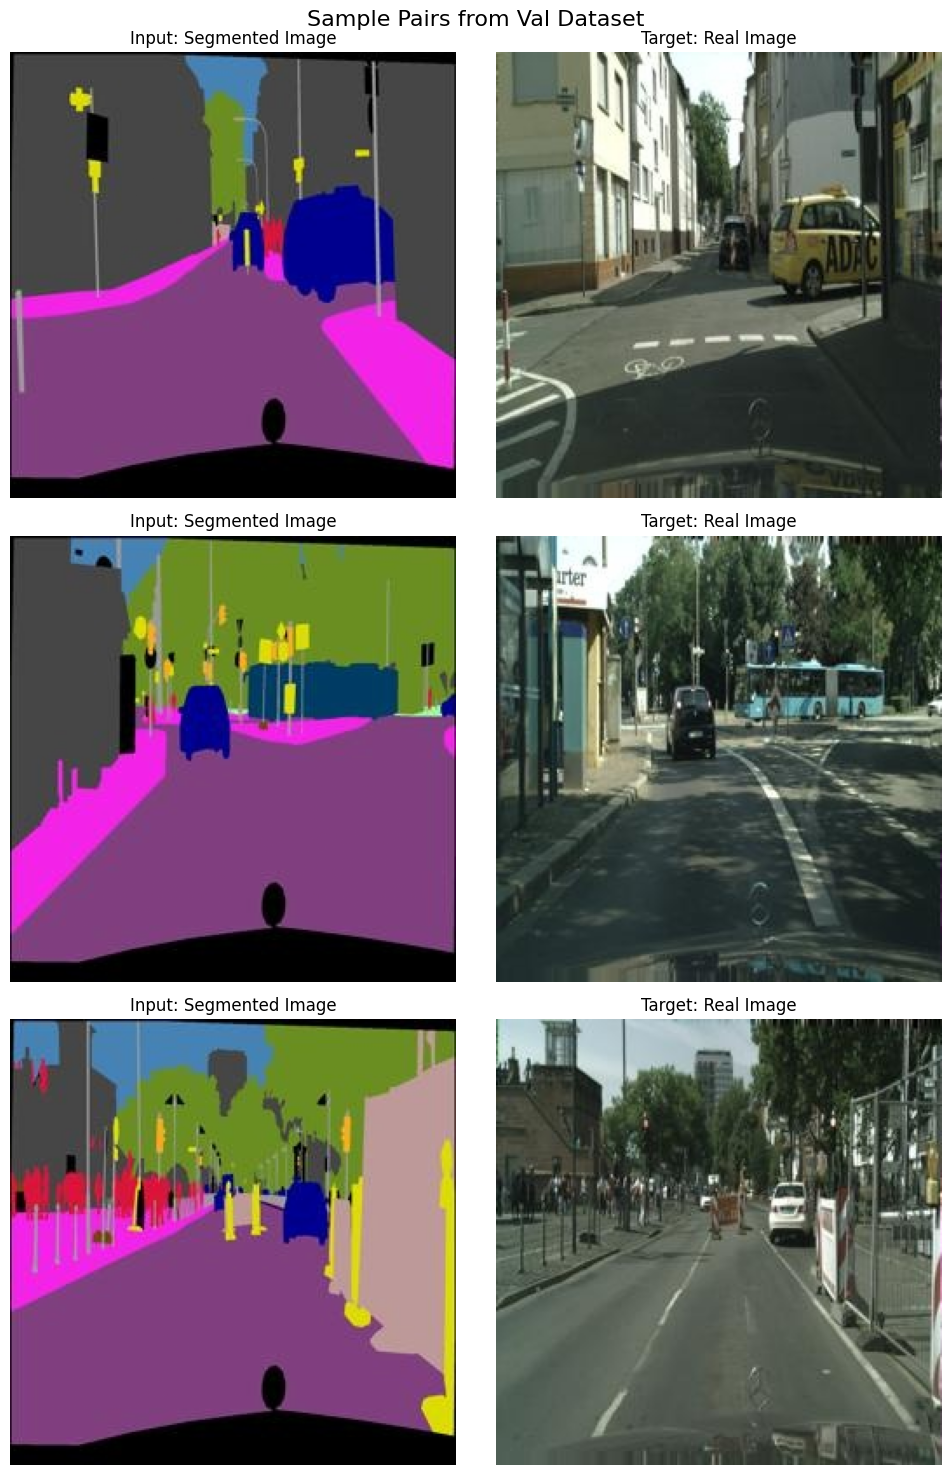

In [ ]:
# Displaying 3 Sample Pairs

def display_sample_pairs(dataset, num_pairs=10, title="Sample Pairs"):

    fig, axes = plt.subplots(num_pairs, 2, figsize=(10, 5 * num_pairs))
    fig.suptitle(title, fontsize=16)

    for i in range(num_pairs):
        segmented_image, real_image = dataset[i]
        segmented_image = segmented_image.permute(1, 2, 0) * 0.5 + 0.5          # denormalize for visualization
        real_image = real_image.permute(1, 2, 0) * 0.5 + 0.5                    # denormalize for visualization
        axes[i, 0].imshow(segmented_image)
        axes[i, 0].set_title("Input: Segmented Image")
        axes[i, 0].axis('off')
        axes[i, 1].imshow(real_image)
        axes[i, 1].set_title("Target: Real Image")
        axes[i, 1].axis('off')
    plt.tight_layout()
    plt.show()

display_sample_pairs(train_dataset, num_pairs=3, title="Sample Pairs from Train Dataset")
display_sample_pairs(val_dataset, num_pairs=3, title="Sample Pairs from Val Dataset")

In [79]:
class Generator(nn.Module):
    def __init__(self, input_channels=12, kernel_size=4, stride=2, padding=1, dropout_rate=0.5):
        super().__init__()

        # Encoder Blocks
        self.e1 = nn.Conv2d(input_channels, 64, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.lr1 = nn.LeakyReLU(0.2, inplace=False)

        self.e2 = nn.Conv2d(64, 128, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.eb2 = nn.BatchNorm2d(128)
        self.lr2 = nn.LeakyReLU(0.2, inplace=False)

        self.e3 = nn.Conv2d(128, 256, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.eb3 = nn.BatchNorm2d(256)
        self.lr3 = nn.LeakyReLU(0.2, inplace=False)

        self.e4 = nn.Conv2d(256, 512, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.eb4 = nn.BatchNorm2d(512)
        self.lr4 = nn.LeakyReLU(0.2, inplace=False)

        self.e5 = nn.Conv2d(512, 512, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.eb5 = nn.BatchNorm2d(512)
        self.lr5 = nn.LeakyReLU(0.2, inplace=False)

        self.e6 = nn.Conv2d(512, 512, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.eb6 = nn.BatchNorm2d(512)
        self.lr6 = nn.LeakyReLU(0.2, inplace=False)

        self.e7 = nn.Conv2d(512, 512, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.eb7 = nn.BatchNorm2d(512)
        self.lr7 = nn.LeakyReLU(0.2, inplace=False)

        self.e8 = nn.Conv2d(512, 512, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.eb8 = nn.BatchNorm2d(512)
        self.lr8 = nn.LeakyReLU(0.2, inplace=False)

        # Decoder Blocks
        self.upconv1 = nn.ConvTranspose2d(512, 512, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.db1 = nn.BatchNorm2d(1024)
        self.do1 = nn.Dropout(dropout_rate)

        self.upconv2 = nn.ConvTranspose2d(1024, 512, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.db2 = nn.BatchNorm2d(1024)
        self.do2 = nn.Dropout(dropout_rate)

        self.upconv3 = nn.ConvTranspose2d(1024, 512, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.db3 = nn.BatchNorm2d(1024)
        self.do3 = nn.Dropout(dropout_rate)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.db4 = nn.BatchNorm2d(1024)
        self.do4 = nn.Dropout(dropout_rate)

        self.upconv5 = nn.ConvTranspose2d(1024, 256, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.db5 = nn.BatchNorm2d(512)

        self.upconv6 = nn.ConvTranspose2d(512, 128, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.db6 = nn.BatchNorm2d(256)

        self.upconv7 = nn.ConvTranspose2d(256, 64, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.db7 = nn.BatchNorm2d(128)

        # Output
        #self.output = nn.Conv2d(128, 1, kernel_size=1, stride=1, padding=0)
        self.output = nn.ConvTranspose2d(128, 3, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)


    def forward(self, x):
        # Encoder
        e1 = self.e1(x)
        lr1 = self.lr1(e1)

        e2 = self.e2(lr1)
        eb2 = self.eb2(e2)
        lr2 = self.lr2(eb2)

        e3 = self.e3(lr2)
        eb3 = self.eb3(e3)
        lr3 = self.lr3(eb3)

        e4 = self.e4(lr3)
        eb4 = self.eb4(e4)
        lr4 = self.lr4(eb4)

        e5 = self.e5(lr4)
        eb5 = self.eb5(e5)
        lr5 = self.lr5(eb5)

        e6 = self.e6(lr5)
        eb6 = self.eb6(e6)
        lr6 = self.lr6(eb6)

        e7 = self.e7(lr6)
        eb7 = self.eb7(e7)
        lr7 = self.lr7(eb7)

        e8 = self.e8(lr7)
        eb8 = self.eb8(e8)
        lr8 = self.lr8(eb8)

        # Decoder
        upconv1 = self.upconv1(lr8)
        upconv1 = torch.cat([upconv1, e7], dim=1)
        db1 = self.db1(upconv1)
        do1 = self.do1(db1)
        d1 = relu(do1)

        upconv2 = self.upconv2(d1)
        upconv2 = torch.cat([upconv2, e6], dim=1)
        db2 = self.db2(upconv2)
        do2 = self.do2(db2)
        d2 = relu(do2)

        upconv3 = self.upconv3(d2)
        upconv3 = torch.cat([upconv3, e5], dim=1)
        db3 = self.db1(upconv3)
        do3 = self.do1(db3)
        d3 = relu(do3)

        upconv4 = self.upconv4(d3) # WAS d3
        upconv4 = torch.cat([upconv4, e4], dim=1)
        db4 = self.db4(upconv4)
        d4 = relu(db4)

        upconv5 = self.upconv5(d4)
        upconv5 = torch.cat([upconv5, e3], dim=1)
        db5 = self.db5(upconv5)
        d5 = relu(db5)

        upconv6 = self.upconv6(d5)
        upconv6 = torch.cat([upconv6, e2], dim=1)
        db6 = self.db6(upconv6)
        d6 = relu(db6)

        upconv7 = self.upconv7(d6)
        upconv7 = torch.cat([upconv7, e1], dim=1)
        db7 = self.db7(upconv7)
        d7 = relu(db7)

        

        # Use tanh 
        out = self.output(d7)
        out = tanh(out)

        return out

    
class Discriminator(nn.Module):
    def __init__(self, input_channels=6, kernel_size=4, stride=2, padding=1):
        super().__init__()

        self.e1 = nn.Conv2d(input_channels, 64, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.lr1 = nn.LeakyReLU(0.2, inplace=False)

        self.e2 = nn.Conv2d(64, 128, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.eb2 = nn.BatchNorm2d(128)
        self.lr2 = nn.LeakyReLU(0.2, inplace=False)

        self.e3 = nn.Conv2d(128, 256, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.eb3 = nn.BatchNorm2d(256)
        self.lr3 = nn.LeakyReLU(0.2, inplace=False)

        self.e4 = nn.Conv2d(256, 512, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.eb4 = nn.BatchNorm2d(512)
        self.lr4 = nn.LeakyReLU(0.2, inplace=False)

        # Output
        self.output = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)

    
    def forward(self, input, target):
        x = torch.cat([input, target], dim=1)
        e1 = self.e1(x)
        lr1 = self.lr1(e1)
        e2 = self.e2(lr1)
        eb2 = self.eb2(e2)
        lr2 = self.lr2(eb2)
        e3 = self.e3(lr2)
        eb3 = self.eb3(e3)
        lr3 = self.lr3(eb3)
        e4 = self.e4(lr3)
        eb4 = self.eb4(e4)
        lr4 = self.lr4(eb4)
        out = self.output(lr4)

        return out
        

In [80]:
class GenLoss(nn.Module):
    def __init__(self, lambd=100):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.lambd = lambd
    
    def forward(self, dis_output, gen_mask, target_mask):
        loss = self.bce(dis_output, torch.ones_like(dis_output))

        # Weighted BCE for class imbalance
        l1_loss = self.lambd * F.l1_loss(gen_mask, target_mask)

        return loss + l1_loss
    

class DiscLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
    
    def forward(self, dis_real_output, disc_gen_output):
        real_loss = self.bce(dis_real_output, torch.ones_like(dis_real_output))
        gen_loss = self.bce(disc_gen_output, torch.zeros_like(disc_gen_output))

        return real_loss + gen_loss


In [81]:
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None:  # Optional: initialize biases if they exist
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

# Model Training

In [82]:
folder_path = './other_gen_models'
gen_input_channels = 3
disc_input_channels = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [83]:
#  Hyperparameters
kernel_size = 4 # DO NOT CHANGE
stride = 2 # DO NOT CHANGE
padding = 1 # DO NOT CHANGE
dropout = 0.5

gen_lr = 1e-4
disc_lr = 1e-4

lambd = 100

num_epochs = 200
patience = 50

In [84]:
generator = Generator(gen_input_channels, kernel_size, stride, padding, dropout)
discriminator = Discriminator(disc_input_channels, kernel_size, stride, padding)

generator.apply(init_weights)
discriminator.apply(init_weights)

generator.to(device)
discriminator.to(device)

Discriminator(
  (e1): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (lr1): LeakyReLU(negative_slope=0.2)
  (e2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (eb2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lr2): LeakyReLU(negative_slope=0.2)
  (e3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (eb3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lr3): LeakyReLU(negative_slope=0.2)
  (e4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (eb4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lr4): LeakyReLU(negative_slope=0.2)
  (output): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
)

In [ ]:
gen_best_val_loss = float('inf')
epochs_no_improve = 0
gen_best_model_state = None
bgen_est_model_filename = None

# Optimizers and loss functions
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=gen_lr, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=disc_lr, betas=(0.5, 0.999))
gen_criterion = GenLoss(lambd=lambd)
disc_criterion = DiscLoss()

# Train over the entire dataset every epoch
for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    gen_total_loss = 0
    disc_total_loss = 0

    # Train in batches 
    for batch in train_loader:
        images, target = batch
        images.to(device)
        target.to(device)
        # Update Discriminator
        disc_optimizer.zero_grad()

        # Generate fake images
        with torch.no_grad():
            generated = generator(images)
        generated_detached = generated.detach()

        # Discriminator loss
        real_pred = discriminator(target, images)
        fake_pred = discriminator(generated_detached, images)
        disc_loss = disc_criterion(real_pred, fake_pred)

        disc_loss.backward()
        disc_optimizer.step()

        # Update generator
        gen_optimizer.zero_grad()

        # Re-forward generator
        generated = generator(images)
        gen_pred = discriminator(generated, images)
        gen_loss = gen_criterion(gen_pred, generated, target)

        gen_loss.backward()
        gen_optimizer.step()

        # Add loss to totals
        gen_total_loss = gen_total_loss + gen_loss.item()
        disc_total_loss = disc_total_loss + disc_loss.item()

    # Average the loss over all batches
    gen_avg_loss = gen_total_loss / len(train_loader)
    disc_avg_loss = disc_total_loss / len(train_loader)


    # Now, validate the model
    generator.eval()
    discriminator.eval()
    gen_val_loss = 0
    disc_val_loss = 0

    # Gradients are not used as validation is used to find the best model without further optimization
    with torch.no_grad():
        # Validate in batches
        for batch in val_loader:
            images, target = batch
            images = images.to(device)
            target = target.to(device)
            
            # Make predictions on the validation images
            generated = generator(images)
            gen_pred = discriminator(generated, images)
            real_pred = discriminator(target, images)

            # Calculate the loss
            gen_loss = gen_criterion(gen_pred, generated, target)
            disc_loss = disc_criterion(real_pred, gen_pred)
            gen_val_loss = gen_val_loss + gen_loss.item()
            disc_val_loss = disc_val_loss + disc_loss.item()


    
    # Average the validation loss over all batches
    gen_avg_val_loss = gen_val_loss / len(val_loader)
    disc_avg_val_loss = disc_val_loss / len(val_loader)
    
    print(f"Epoch {epoch + 1}/{num_epochs}\
          \n   - Generator Train Loss: {gen_avg_loss:.4f} - Generator Validation Loss: {gen_avg_val_loss:.4f}\
          \n   - Discriminator Train Loss: {disc_avg_loss:.4f} - Discriminator Validation Loss: {disc_avg_val_loss:.4f}")

    # Best model saving & early stopping
    if gen_avg_val_loss < gen_best_val_loss:
        gen_best_val_loss = gen_avg_val_loss
        epochs_no_improve = 0
        gen_best_model_state = generator.state_dict() 
        gen_best_model_filename = f"{folder_path}/best_model_{str(gen_best_val_loss)}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pth"
        print("Validation loss improved. Best model updated.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")
    
    if epochs_no_improve >= patience:
        print("Early stopping triggered!")
        break

In [ ]:
# save the best model
os.makedirs('./other_gen_models', exist_ok=True)
if gen_best_model_state is not None:
    torch.save(gen_best_model_state, gen_best_model_filename)
    print(f"Best model saved to {gen_best_model_filename}")

In [ ]:
def display_generated_samples(model, loader, num_samples=10, title="Generated Samples"):

    model.eval()
    with torch.no_grad():
        segmented_images, real_images = next(iter(loader))
        segmented_images = segmented_images[:num_samples].to(device)
        real_images = real_images[:num_samples].to(device)

        fake_images = model.generator(segmented_images)

        fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
        fig.suptitle(title, fontsize=16)

        for i in range(num_samples):
            axes[i, 0].imshow((segmented_images[i].permute(1, 2, 0).cpu().numpy() + 1) / 2)         # denormalizing
            axes[i, 0].set_title("Input Image")
            axes[i, 0].axis('off')
            axes[i, 1].imshow((real_images[i].permute(1, 2, 0).cpu().numpy() + 1) / 2)              # denormalizing
            axes[i, 1].set_title("Target Image")
            axes[i, 1].axis('off')
            axes[i, 2].imshow((fake_images[i].permute(1, 2, 0).cpu().numpy() + 1) / 2)              # denormalizing
            axes[i, 2].set_title("Generated Image")
            axes[i, 2].axis('off')

        plt.tight_layout()
        plt.show()

In [ ]:
generator.load_state_dict(torch.load(gen_best_model_filename, map_location=device))

In [ ]:
display_generated_samples(generator, train_loader, num_samples=5, title="Generated Samples from Train Dataset\n\n\n\n")
display_generated_samples(generator, val_loader, num_samples=5, title="Generated Samples from Val Dataset\n\n\n\n")